In [58]:
# Parameters
project_folder = "c:\\\\Users\\\\Sara Bonati\\\\Desktop\\\\MPI_work\\\\Machines\\\\Reward_network_task"
solution_columns = ["network_id", "strategy", "step", "source_node", "current_node", "reward", "total_reward"]


# Rule

* in general always take the edge with the larger payoff
* however: take the first large loss (only the first)

In [71]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import os
import glob
import json
import random
import logging
sns.set_theme()

from environment import Reward_Network

c:\Users\Sara Bonati\Desktop\MPI_work\Machines\Reward_network_task\reward-network-iii-algorithm\.venv\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\Sara Bonati\Desktop\MPI_work\Machines\Reward_network_task\reward-network-iii-algorithm\.venv\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [72]:
project_folder= 'c:\\Users\\Sara Bonati\\Desktop\\MPI_work\\Machines\\Reward_network_task'
solution_columns= ['network_id','strategy','step','source_node','current_node','reward','total_reward']

In [73]:
# directory management
code_dir = os.path.join(project_folder,'reward-network-iii-algorithm')
data_dir = os.path.join(project_folder,'data','rawdata')
solutions_dir = os.path.join(project_folder,'data','solutions')
to_log=False

### define agent class

In [74]:
class Rule_Agent:

    def __init__(self,strategy):

        # assert tests
        assert strategy in ['highest_payoff','take_first_loss','random'], f'Strategy name must be one of {["highest_payoff","take_first_loss","random"]}, got {strategy}'
        
        self.strategy =  strategy        
        self.colors = {'highest_payoff':'skyblue','take_first_loss':'orangered','random':'springgreen'}


    def select_action(self):
        """
        This method finds possible actions from the current node and
        selects one based on current strategy
        """
        
        self.possible_actions = [a for a in self.environment.action_space if a['source_id']==self.environment.current_node]
        self.possible_actions_rewards = np.asarray([a['reward'] for a in self.environment.action_space if a['source_id']==self.environment.current_node])
        
        print(self.environment.current_node)
        print(self.possible_actions)
        if self.strategy=='random':
            return random.choice(self.possible_actions)

        # take first loss -> select among possible actions the one that gives best reward BUT make sure to take a first big loss
        if self.strategy == 'take_first_loss' and self.loss_counter<1 and -100 in self.possible_actions_rewards:
            self.loss_counter +=1
            #print(f'take first loss {self.possible_actions[np.argwhere(self.possible_actions_rewards==-100)[0][0]]}')
            #print('\n')
            return self.possible_actions[np.argwhere(self.possible_actions_rewards==-100)[0][0]]
            
        else:
            # highest payoff -> select among possible actions the one that gives best reward
            #print(f'take highest payoff {self.possible_actions[np.argmax(self.possible_actions_rewards)]}')
            #print('\n')
            try:
                return self.possible_actions[np.argmax(self.possible_actions_rewards)]
            except:
                print('Error')
                print(self.environment.id)
                print(self.environment.action_space)

    def solve(self,network):
        """ 
        the agent solves the task, with different constraints depending on the strategy.
        Returns solved reward network in tabular form
        """
        if self.strategy == 'take_first_loss':
            self.loss_counter = 0 # to reset!

        self.solution = []
        self.solution_filename = os.path.join(solutions_dir,f'{network["network_id"]}_Solution_log_{self.strategy}.csv')    
        
        self.environment = Reward_Network(network)
        self.environment.reset()
        
        while self.environment.is_done==False:
            s = []
            a = self.select_action()
            obs = self.environment.step(a)
            
            s.append(self.environment.id)
            s.append(self.strategy)
            s.append(obs['n_steps'])
            s.append(obs['source_node'])
            s.append(obs['current_node'])
            s.append(obs['reward'])
            s.append(obs['total_reward'])
            self.solution.append(s)

        self.solution_df = pd.DataFrame(self.solution, columns = solution_columns)
        self.solution_df.to_csv(self.solution_filename,sep='\t')

    def save_solutions(self):
        self.all_solutions_filename = os.path.join(solutions_dir,f'{self.strategy}_train.csv')
        self.solutions_fn = glob.glob(solutions_dir+f'/*{self.strategy}*.csv')
        self.df = pd.concat([pd.read_csv(s,sep='\t') for s in self.solutions_fn],ignore_index=True)
        self.df.to_csv(self.all_solutions_filename,sep='\t')

    def inspect_solutions(self):
        self.df = pd.read_csv(os.path.join(solutions_dir,f'{self.strategy}_train.csv'),sep='\t')
        g = sns.displot(data=self.df[self.df['step']==8], x="total_reward", kde=True, color=self.colors[self.strategy])
        g.set(xlim=(-400,400),xlabel='Final reward',ylabel='Count')
        plt.show()

## Solve networks + compare strategies' results

In [75]:
with open(os.path.join(data_dir,'train.json')) as json_file:
    train = json.load(json_file)

In [76]:
print("-------A (highest payoff)-------")
A = Rule_Agent('highest_payoff')

for network in train:
    A.solve(network)
print('\n')

-------A (highest payoff)-------
dict_keys(['network_id', 'nodes', 'edges', 'starting_node', 'max_reward'])
0
[{'source_id': 0, 'target_id': 2, 'reward': -20}, {'source_id': 0, 'target_id': 5, 'reward': -100}]
2
[{'source_id': 2, 'target_id': 3, 'reward': -20}, {'source_id': 2, 'target_id': 1, 'reward': 0}]
1
[{'source_id': 1, 'target_id': 4, 'reward': 20}, {'source_id': 1, 'target_id': 0, 'reward': 20}]
4
[{'source_id': 4, 'target_id': 0, 'reward': -20}, {'source_id': 4, 'target_id': 2, 'reward': 20}]
2
[{'source_id': 2, 'target_id': 3, 'reward': -20}, {'source_id': 2, 'target_id': 1, 'reward': 0}]
1
[{'source_id': 1, 'target_id': 4, 'reward': 20}, {'source_id': 1, 'target_id': 0, 'reward': 20}]
4
[{'source_id': 4, 'target_id': 0, 'reward': -20}, {'source_id': 4, 'target_id': 2, 'reward': 20}]
2
[{'source_id': 2, 'target_id': 3, 'reward': -20}, {'source_id': 2, 'target_id': 1, 'reward': 0}]
dict_keys(['network_id', 'nodes', 'edges', 'starting_node', 'max_reward'])
0
[{'source_id': 0, 

In [77]:
print("-------B (take_first_loss)-------")
B = Rule_Agent('take_first_loss')

for network in train:
    B.solve(network)
print('\n')

-------B (take_first_loss)-------
dict_keys(['network_id', 'nodes', 'edges', 'starting_node', 'max_reward'])
0
[{'source_id': 0, 'target_id': 2, 'reward': -20}, {'source_id': 0, 'target_id': 5, 'reward': -100}]
5
[{'source_id': 5, 'target_id': 6, 'reward': 0}, {'source_id': 5, 'target_id': 3, 'reward': 0}]
6
[{'source_id': 6, 'target_id': 7, 'reward': 0}, {'source_id': 6, 'target_id': 8, 'reward': 20}]
8
[{'source_id': 8, 'target_id': 9, 'reward': 20}, {'source_id': 8, 'target_id': 6, 'reward': 20}]
9
[{'source_id': 9, 'target_id': 8, 'reward': 140}, {'source_id': 9, 'target_id': 7, 'reward': 140}]
8
[{'source_id': 8, 'target_id': 9, 'reward': 20}, {'source_id': 8, 'target_id': 6, 'reward': 20}]
9
[{'source_id': 9, 'target_id': 8, 'reward': 140}, {'source_id': 9, 'target_id': 7, 'reward': 140}]
8
[{'source_id': 8, 'target_id': 9, 'reward': 20}, {'source_id': 8, 'target_id': 6, 'reward': 20}]
dict_keys(['network_id', 'nodes', 'edges', 'starting_node', 'max_reward'])
0
[{'source_id': 0, 

In [78]:
print("-------C (random)-------")
C = Rule_Agent('random')

for network in train:
    C.solve(network)
print('\n')

-------C (random)-------
dict_keys(['network_id', 'nodes', 'edges', 'starting_node', 'max_reward'])
0
[{'source_id': 0, 'target_id': 2, 'reward': -20}, {'source_id': 0, 'target_id': 5, 'reward': -100}]
2
[{'source_id': 2, 'target_id': 3, 'reward': -20}, {'source_id': 2, 'target_id': 1, 'reward': 0}]
1
[{'source_id': 1, 'target_id': 4, 'reward': 20}, {'source_id': 1, 'target_id': 0, 'reward': 20}]
4
[{'source_id': 4, 'target_id': 0, 'reward': -20}, {'source_id': 4, 'target_id': 2, 'reward': 20}]
2
[{'source_id': 2, 'target_id': 3, 'reward': -20}, {'source_id': 2, 'target_id': 1, 'reward': 0}]
1
[{'source_id': 1, 'target_id': 4, 'reward': 20}, {'source_id': 1, 'target_id': 0, 'reward': 20}]
0
[{'source_id': 0, 'target_id': 2, 'reward': -20}, {'source_id': 0, 'target_id': 5, 'reward': -100}]
5
[{'source_id': 5, 'target_id': 6, 'reward': 0}, {'source_id': 5, 'target_id': 3, 'reward': 0}]
dict_keys(['network_id', 'nodes', 'edges', 'starting_node', 'max_reward'])
0
[{'source_id': 0, 'target_

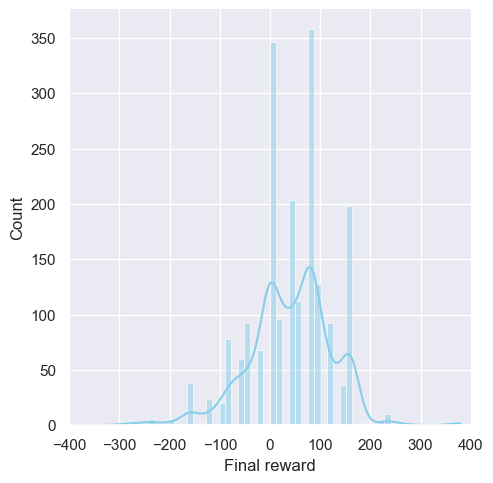

In [79]:
A.save_solutions()
A.inspect_solutions()

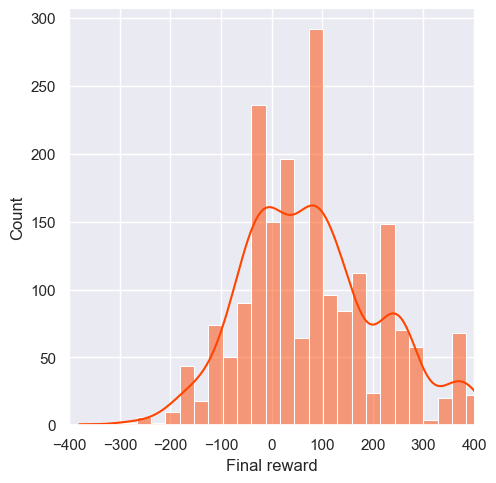

In [80]:
B.save_solutions()
B.inspect_solutions()

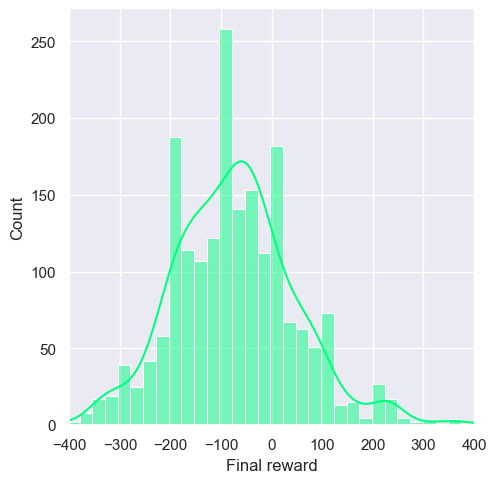

In [81]:
C.save_solutions()
C.inspect_solutions()

## analyze solution final rewards and compare the different strategies

c:\Users\Sara Bonati\Desktop\MPI_work\Machines\Reward_network_task\reward-network-iii-algorithm\.venv\lib\site-packages\seaborn\axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


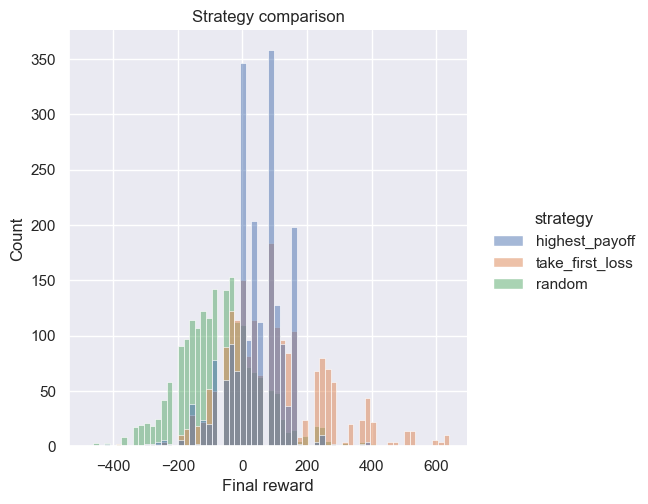

In [88]:
if os.path.exists(A.all_solutions_filename) and os.path.exists(B.all_solutions_filename) and os.path.exists(C.all_solutions_filename):
    # load solution data 
    strategy_A = pd.read_csv(A.all_solutions_filename,sep='\t')
    strategy_A = strategy_A[strategy_A['step']==8]
    strategy_B = pd.read_csv(B.all_solutions_filename,sep='\t')
    strategy_B = strategy_B[strategy_B['step']==8]
    strategy_C = pd.read_csv(C.all_solutions_filename,sep='\t')
    strategy_C = strategy_C[strategy_C['step']==8]
    
    strategy_data = pd.concat([strategy_A,strategy_B,strategy_C],ignore_index=True)[solution_columns]
    strategy_data.to_csv(os.path.join(solutions_dir,'ALL_SOLUTIONS.csv'),sep='\t')


    g=sns.displot(data=strategy_data, x="total_reward", hue="strategy", kind="hist")
    g.set(xlabel='Final reward',ylabel='Count',title=f'Strategy comparison')
    plt.show()

In [89]:
strategy_data.head(40)

,network_id,strategy,step,source_node,current_node,reward,total_reward
0,dev_train_0,highest_payoff,8,2,1,0,60
1,dev_train_100,highest_payoff,8,3,2,0,60
2,dev_train_101,highest_payoff,8,2,0,20,80
3,dev_train_102,highest_payoff,8,1,6,20,20
4,dev_train_103,highest_payoff,8,1,3,0,-60
5,dev_train_104,highest_payoff,8,3,2,20,160
6,dev_train_105,highest_payoff,8,1,0,-20,0
7,dev_train_106,highest_payoff,8,4,0,20,0
8,dev_train_107,highest_payoff,8,1,4,0,60
9,dev_train_108,highest_payoff,8,2,0,0,40


In [92]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

model = ols('total_reward ~ strategy',data=strategy_data).fit()
table = sm.stats.anova_lm(model, typ=2) 
print(table)

                sum_sq      df           F  PR(>F)
strategy  2.777754e+07     2.0  904.804824     0.0
Residual  9.119444e+07  5941.0         NaN     NaN


In [93]:
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=strategy_data['total_reward'],
                          groups=strategy_data['strategy'],
                          alpha=0.05)

#display results
print(tukey)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1          group2      meandiff p-adj   lower     upper   reject
-------------------------------------------------------------------------
highest_payoff          random -112.9292   0.0 -122.1798 -103.6786   True
highest_payoff take_first_loss     51.38   0.0   42.1953   60.5647   True
        random take_first_loss  164.3092   0.0  155.0586  173.5598   True
-------------------------------------------------------------------------


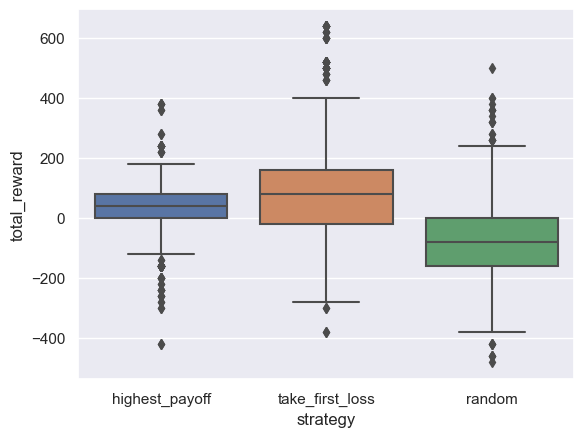

In [94]:
sns.boxplot(x="strategy", y="total_reward", data=strategy_data)
plt.show()

## inspect solutions more closely

In [68]:
strategy_A = pd.read_csv(A.solution_filename,sep='\t')
strategy_B = pd.read_csv(B.solution_filename,sep='\t')

strategy_A_wide = strategy_A.pivot(index="network_id", columns="step", values="reward")
strategy_A_wide.head(30)

step,1,2,3,4,5,6,7,8
network_id,,,,,,,,
dev_train_0,-20,0,20,20,0,20,20,0
dev_train_1,20,20,0,20,0,20,0,20
dev_train_10,20,20,20,20,20,20,20,20
dev_train_100,0,0,20,0,20,0,20,0
dev_train_101,0,20,0,20,0,20,0,20
dev_train_102,20,0,0,20,-20,-20,0,20
dev_train_103,-20,0,0,-20,0,0,-20,0
dev_train_104,20,20,20,20,20,20,20,20
dev_train_105,20,-20,20,-20,20,-20,20,-20


In [69]:
strategy_B_wide = strategy_B.pivot(index="network_id", columns="step", values="reward")
strategy_B_wide.head(30)

step,1,2,3,4,5,6,7,8
network_id,,,,,,,,
dev_train_0,-100,0,20,20,140,20,140,20
dev_train_1,20,20,0,20,0,20,0,20
dev_train_10,20,20,20,20,20,20,20,20
dev_train_100,0,0,20,0,20,0,20,0
dev_train_101,0,20,0,20,0,20,0,20
dev_train_102,20,0,0,20,-20,-20,0,20
dev_train_103,-20,0,0,-20,0,0,-20,0
dev_train_104,20,20,20,20,20,20,20,20
dev_train_105,20,-20,20,-20,20,-20,20,-20


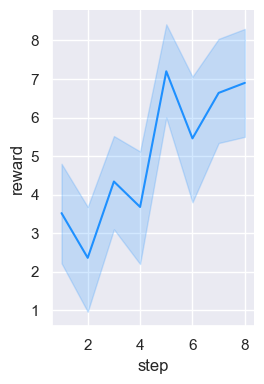

In [16]:
g = sns.relplot(
    data=strategy_A,
    x="step", y="reward",
    height=4, aspect=.7, kind="line",color='dodgerblue'
)
plt.show()